In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
%matplotlib inline

In [2]:
full = pd.read_csv('full_feature_cleaned.csv')
full.head()

,timestamp,load,weathertime,temperature,dewpoint,humidity,pressure,wind_dir,wind_speed,precip,...,uv_index,dow,doy,day,month,hour,minute,t_m24,t_m48,tdif
0,2012-10-27 00:05:00,700.7,2012-10-27 00:08:00,11.2,9.9,92,1018.8,SW,4.8,0.0,...,0.0,5,301,27,10,0,5,700.7,700.7,0.0
1,2012-10-27 00:10:00,694.7,2012-10-27 00:08:00,11.2,9.9,92,1018.8,SW,4.8,0.0,...,0.0,5,301,27,10,0,10,694.7,694.7,0.0
2,2012-10-27 00:15:00,692.8,2012-10-27 00:14:00,11.3,9.9,91,1018.8,SW,6.4,0.0,...,0.0,5,301,27,10,0,15,692.8,692.8,0.0
3,2012-10-27 00:20:00,686.5,2012-10-27 00:25:00,11.2,9.9,92,1018.8,SW,3.2,0.0,...,0.0,5,301,27,10,0,20,686.5,686.5,0.0
4,2012-10-27 00:25:00,685.3,2012-10-27 00:25:00,11.2,9.9,92,1018.8,SW,3.2,0.0,...,0.0,5,301,27,10,0,25,685.3,685.3,0.0


In [3]:
full['timestamp'] = full.timestamp.apply(lambda x: pd.to_datetime(x))

In [24]:
def deviance_plot(est, X_test, y_test, ax = None, label = '', train_color='#2c7bb6', test_color = '#d7191c', alpha= 1.0, ylim = (0,60000)):

    n_estimators = len(est.estimators_)
    test_dev = np.empty(n_estimators)

    for i, pred in enumerate(est.staged_predict(X_test)):
        test_dev[i] = est.loss_(y_test, pred)

    if ax is None:
        fig = plt.figure(figsize = (18,6))
        ax = plt.gca()

    ax.plot(np.arange(n_estimators) + 1, test_dev, color= test_color, label = 'Test %s' % label, linewidth=2, alpha=alpha)
    ax.plot(np.arange(n_estimators) + 1, est.train_score_, color = train_color, label= 'Train %s' % label, linewidth=2, alpha=alpha)
    ax.set_ylabel('Error')
    ax.set_xlabel('n_estimators')
    ax.set_ylim(ylim)
    ax.legend(loc='upper right')
    return test_dev, ax

def get_daily_values(X_test, y_test, gbr, full):
    p = X_test.copy()
    p['load'] = y_test
    p['times'] = full[full.timestamp >= pd.to_datetime('2014')]['timestamp']
    p['prediction'] = gbr.predict(X_test)
    p['error'] = np.abs(p['load'] - p['prediction'])
    p = p.set_index(p.times)
    daily_values = p.groupby(pd.TimeGrouper(freq='D')).aggregate(np.max)
    return daily_values

def plot_model_performance(X_test, y_test, gbr, full):
    daily_values = get_daily_values(X_test, y_test, gbr, full)
    times = daily_values.index
    fig, ax1 = plt.subplots(figsize=(18, 6),)
    ax1.plot(times, daily_values['load'], alpha=.5, color='blue', label='actual load' )
    ax1.plot(times, daily_values['prediction'], alpha=.5, color='red', label="Dan's predicted load, %.3f" %gbr.score(X_test, y_test))
    ax1.plot(times, daily_values['error'], alpha=.5, color = 'green', label='error')
    ax1.legend(loc='best')
    ax2 = ax1.twinx()
    ax2.plot(times, daily_values['temperaturef'], alpha = .5, color = 'orange', label='temperature')
#     ax2.plot(times, daily_values['discomfort_index'], alpha = .5, color = 'brown', label='discomfort_index')

#     ax2.plot(times, daily_values['dewpointf'], alpha = .5, color = 'yellow', label='dew point')
#     ax2.plot(times, daily_values['precipitationin'], alpha = .5, color = 'brown', label='precip')
    ax2.legend(loc='lower right')
    return ax1, ax2

def plot_days(gbr, full, day1='2016-02-29', day2='2016-03-02', weather=False):
    test_day = full[full.timestamp >= pd.to_datetime(day1)]
    test_day = test_day[test_day.timestamp < pd.to_datetime(day2)]
    predictions = gbr.predict(test_day[features])
    score = gbr.score(test_day[features], test_day['load'])    
    
    fig, ax = plt.subplots(figsize=(18, 6),)
    ax.plot(test_day.timestamp.values, test_day.load.values, label = 'actual load', color = 'blue')
    ax.plot(test_day.timestamp.values, predictions, label = "Our predicted load. R^2 = %.2f"%score, color= 'red')
    if weather == True:
        ax2 = ax.twinx()
        ax2.plot(test_day.timestamp.values, test_day.temperaturef.values, label = 'temperature', color= 'orange')
    ax.legend(loc='best')
    ax.set_title(day1 + ' - '+ day2 + ' \n NYISO Capital Region ')
    ax.set_xlabel('time')
    ax.set_ylabel('load (megawatts)')
    return ax
    

In [6]:
features = [
    'temperature', 
    'dewpoint',
    'humidity', 
    'pressure', 
    'wind_speed', 
#     'precip',
#     'solarradiation', 
#     'uv_index', 
    'dow', 
    'doy', 
    'day', 
#     'month', 
#     'hour',
    'minute', 
    't_m24', 
    't_m48', 
#     'tdif'
]

In [7]:
X_train = full[full.timestamp < pd.to_datetime('2015-10-01 00:00:00')][features]
X_test = full[full.timestamp >= pd.to_datetime('2015-10-01 00:00:00')][features]

y_train = full[full.timestamp < pd.to_datetime('2015-10-01 00:00:00')]['load']
y_test = full[full.timestamp >= pd.to_datetime('2015-10-01 00:00:00')]['load']

In [8]:
X_train.head()

,temperature,dewpoint,humidity,pressure,wind_speed,dow,doy,day,minute,t_m24,t_m48
0,11.2,9.9,92,1018.8,4.8,5,301,27,5,700.7,700.7
1,11.2,9.9,92,1018.8,4.8,5,301,27,10,694.7,694.7
2,11.3,9.9,91,1018.8,6.4,5,301,27,15,692.8,692.8
3,11.2,9.9,92,1018.8,3.2,5,301,27,20,686.5,686.5
4,11.2,9.9,92,1018.8,3.2,5,301,27,25,685.3,685.3


In [11]:
gbr = GradientBoostingRegressor(loss='ls', n_estimators=100, max_depth=5, verbose=1, warm_start=True)

In [12]:
gbr_fitted = gbr.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1       16008.9766           34.81s
         2       13082.8218           33.98s
         3       10709.6641           35.34s
         4        8784.3686           35.77s
         5        7223.4368           35.61s
         6        5956.5451           36.32s
         7        4928.7427           35.03s
         8        4094.5822           33.95s
         9        3417.1541           33.20s
        10        2864.6287           32.51s
        20         741.1627           27.02s
        30         438.2779           22.55s
        40         371.4012           19.08s
        50         346.5357           15.61s
        60         330.5720           12.45s
        70         320.7046            9.32s
        80         312.2112            6.15s
        90         306.1482            3.07s
       100         300.1003            0.00s


In [13]:
gbr.score(X_test, y_test)

0.72870486726642425

In [14]:
for i in zip(features,[round(float(i), 4) for i in gbr.feature_importances_]):
    print(i)

('temperature', 0.0775)
('dewpoint', 0.057)
('humidity', 0.0283)
('pressure', 0.0613)
('wind_speed', 0.0227)
('dow', 0.062)
('doy', 0.1278)
('day', 0.0357)
('minute', 0.0919)
('t_m24', 0.2362)
('t_m48', 0.1997)


[Text(0,0,'temperature'),
 Text(0,0,'dewpoint'),
 Text(0,0,'humidity'),
 Text(0,0,'pressure'),
 Text(0,0,'wind_speed'),
 Text(0,0,'dow'),
 Text(0,0,'doy'),
 Text(0,0,'day'),
 Text(0,0,'minute'),
 Text(0,0,'t_m24'),
 Text(0,0,'t_m48')]

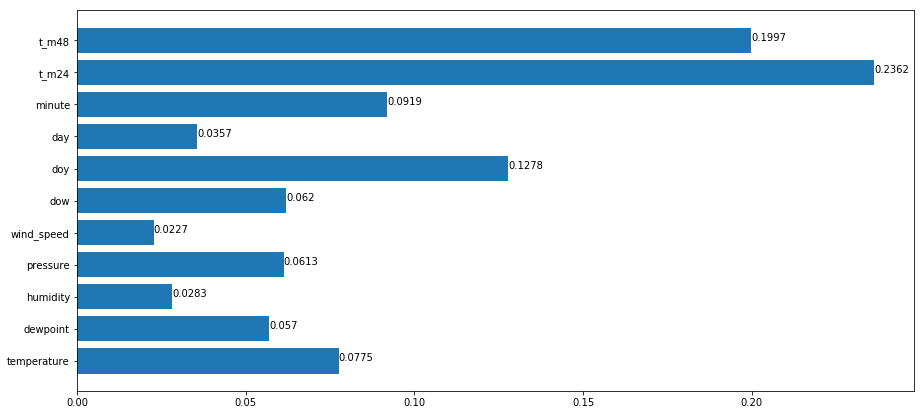

In [15]:
fi = [round(float(i), 4) for i in gbr.feature_importances_]
fig,ax = plt.subplots(figsize=(15,7),)
ax.barh(np.arange(len(fi)), fi)
for i,v in enumerate(fi):
    ax.text(v, i, str(v))
ax.set_yticks(np.arange(len(fi)))
ax.set_yticklabels(features)

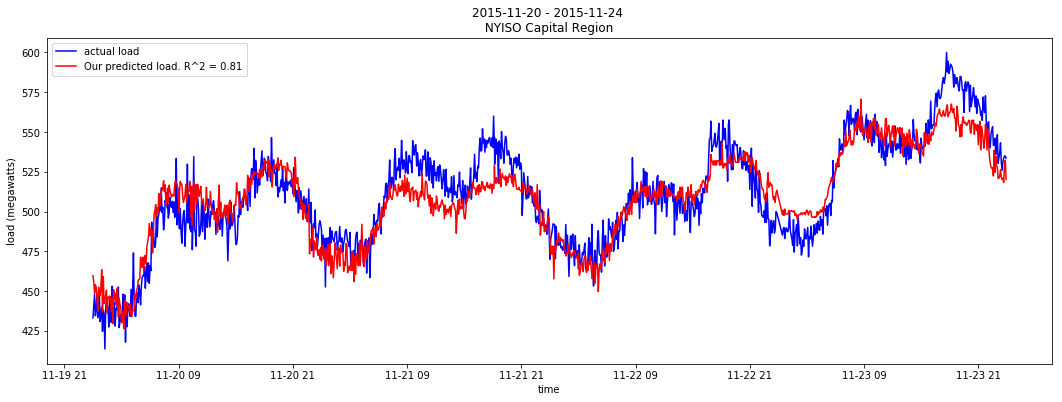

In [25]:
plot_days(gbr, full, '2015-11-20', '2015-11-24')

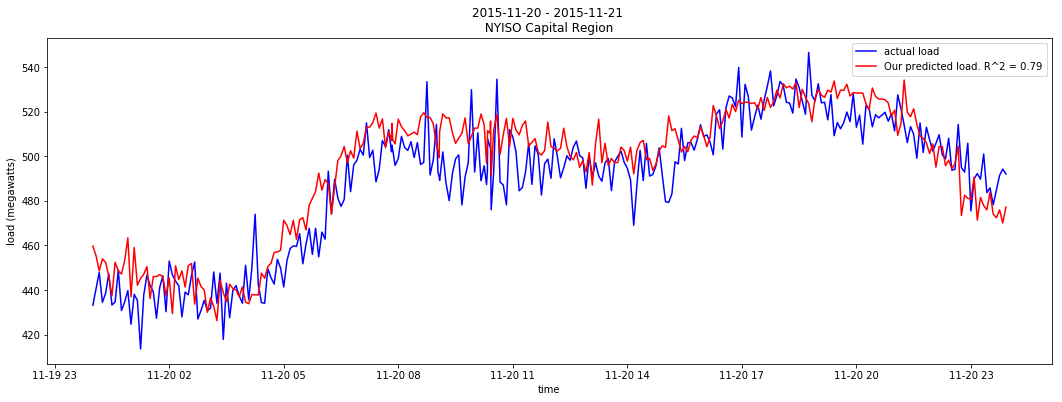

In [26]:
plot_days(gbr, full, '2015-11-20', '2015-11-21')

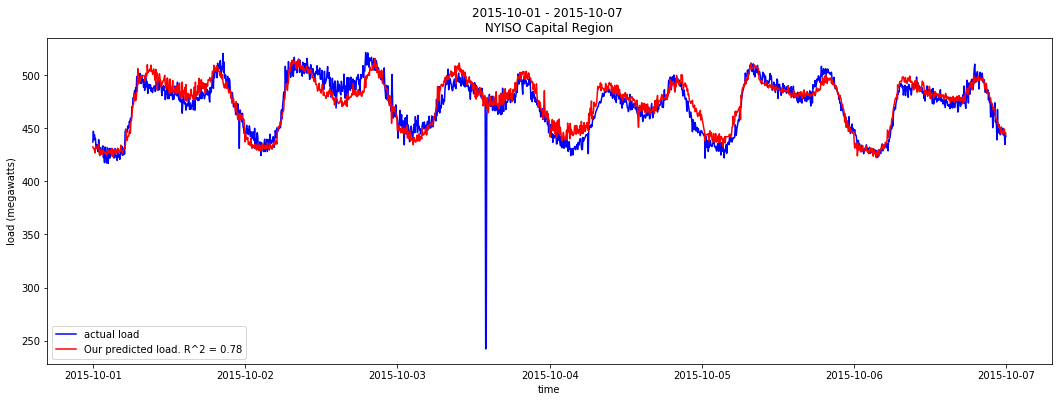

In [28]:
plot_days(gbr, full, '2015-10-01', '2015-10-07')

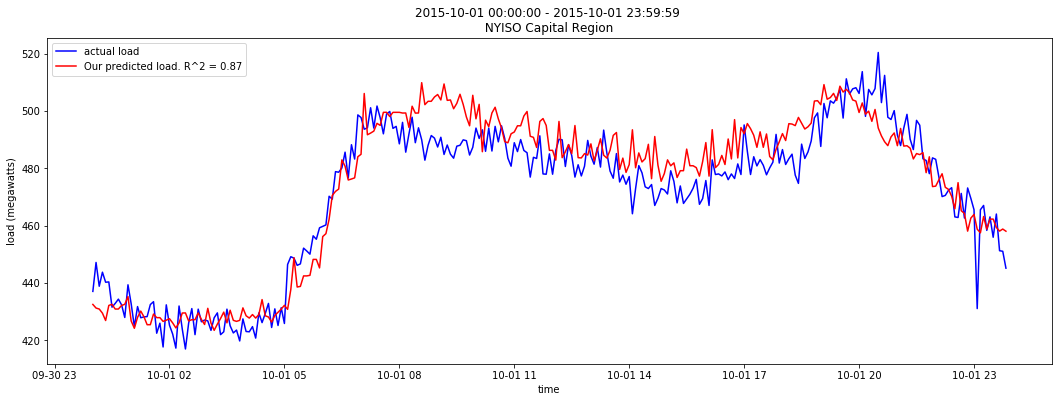

In [31]:
plot_days(gbr, full, '2015-10-01 00:00:00', '2015-10-01 23:59:59')

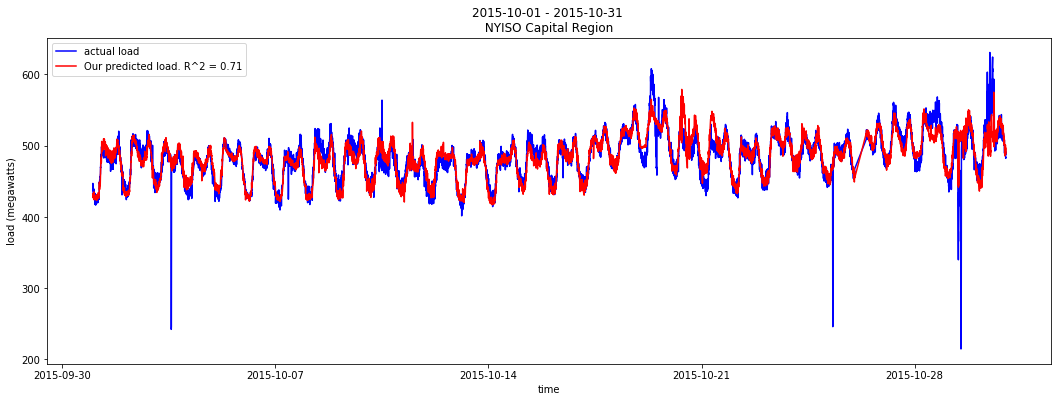

In [30]:
plot_days(gbr, full, '2015-10-01', '2015-10-31')